In [1]:
import prettymaps
import pandas as pd
import json
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, Polygon
import datetime
import itertools
import os
import glob
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint, LineString
from shapely.ops import split
from pyproj import Geod
import requests
import time

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
COMMUNES_FILE = 'data/communes-martinique.geojson'

In [3]:
gdf_mq = gpd.read_file(COMMUNES_FILE)
gdf_mq.code = gdf_mq.code.astype(int)
initial_crs = gdf_mq.geometry.crs.srs            

In [13]:
NB_RETRY = 3
zoom = 6

# around mq
Xmin=9
Xmax=15
Ymin=13
Ymax=15

s = requests.session()
s.cookies.set("SERVERID", "app5nzs", domain="marinetraffic.com")
s.cookies.set("vTo", "1", domain="marinetraffic.com")
my_headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/109.0',
             'Referer': 'https://www.marinetraffic.com/en/ais/home/centerx:-84.1/centery:15.1/zoom:6',
             'Vessel-Image': '00f0c27df0038bb4f3115f6b9451013b2929'}
s.headers.update(my_headers)

dfs = []
for y in range(Ymin, Ymax + 1):
    for x in range(Xmin, Xmax + 1):
        url = f'https://www.marinetraffic.com/getData/get_data_json_4/z:{zoom}/X:{x}/Y:{y}/station:0'
        for r in range(NB_RETRY):
            req = s.get(url)
            if req.status_code == 200:
                dfs.append(req.json())
                break
            # error, what to do now ?
            print(req.status_code, url)
            # let's wait a bit
            time.sleep(0.5)

data = []
for single in dfs:
    data += single['data']['rows']
    
df = pd.read_json(json.dumps(data), orient='records')
# still python 3.9 (haaa)
output_file = f'data/ais/{datetime.datetime.now(tz=datetime.timezone.utc).strftime("%Y%m%d-%H%M%S")}.csv'
df.to_csv(output_file, index=False)
print(f"-> {output_file}")

400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:13/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:14/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:14/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:11/Y:14/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:14/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:14/station:0
400 https://www.marinetraffic.com/getData/get_data_json_4/z:6/X:12/Y:14/station:0
400 https://www.

In [15]:
dfs = []
for input_path in glob.glob('data/ais/*'):
    df = pd.read_csv(input_path)
    dt = datetime.datetime.strptime(f"{input_path.split('/')[-1][:-4]} Z", "%Y%m%d-%H%M%S %z")
    df['dt'] = pd.to_datetime(dt)
    print(dt)
    dfs.append(df)
df = pd.concat(dfs)

2022-11-26 19:49:17+00:00
2022-11-26 22:09:52+00:00
2022-11-26 19:22:01+00:00
2022-11-26 19:00:01+00:00
2022-11-26 20:08:53+00:00
2022-11-26 20:40:18+00:00
2022-11-26 20:36:54+00:00


In [16]:
df['real_time'] = df['dt'] - pd.to_timedelta(df['ELAPSED'].astype(int), 'minute')
#df.sort_values('SHIP_ID').drop_duplicates().head(50)
df['geometry'] = df[['LAT', 'LON']].apply(lambda x: Point(x.LON, x.LAT), axis=1)

gdf = gpd.GeoDataFrame(df)

/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [17]:
def create_lines(x):
    elts = x.sort_values('real_time')[['LON', 'LAT']].drop_duplicates()
    arr = list(zip(elts.LON.values, elts.LAT.values))
    
    if len(arr) == 1:
        return Point(arr[0])
    else:
        return LineString(arr)

post = df[['SHIP_ID', 'LAT', 'LON', 'real_time']].groupby('SHIP_ID').apply(create_lines)


/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [18]:


a = gpd.GeoDataFrame(geometry=post).reset_index(drop=True)#.columns

In [19]:
a

,geometry
0,"LINESTRING (-14.95675 25.58836, -14.98209 25.5..."
1,"LINESTRING (-77.43861 25.28878, -77.49627 25.4..."
2,POINT (-60.50029 10.80740)
3,"LINESTRING (-76.99812 26.77121, -77.40919 27.0..."
4,POINT (-16.56160 28.05083)
...,...
17221,POINT (-57.86997 15.97934)
17222,POINT (-77.39667 22.13500)
17223,POINT (-23.71461 21.30136)
17224,POINT (-26.30783 21.84926)


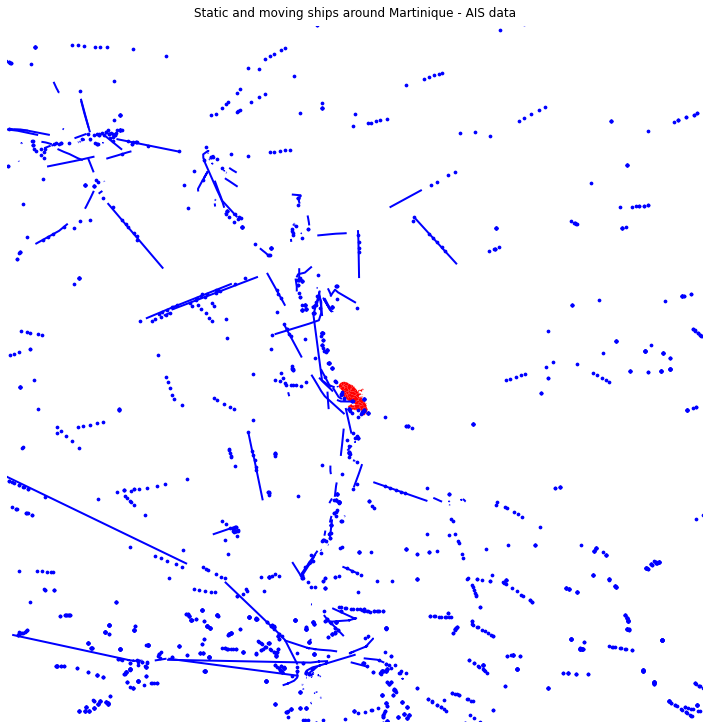

In [25]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle("Static and moving ships around Martinique - AIS data")

#gdf.plot(ax=ax,color="black", legend=False, markersize=1)#, figsize=(15,15), linewidth=0, edgecolor='white', color=X["t"])
gdf_mq.plot(ax=ax, color="red")#, linewidth=100)#, linewidth=1, edgecolor='white')
a.plot(ax=ax, color="blue",  markersize=3, linewidth=2)

_ = ax.axis('off')
ax.set_xlim([-66,-56])
ax.set_ylim([10,20])
fig.savefig('output/2022-11-26.png', facecolor='white')